In [1]:
import numpy as np
import sys
sys.path.append('./')

In [2]:
# training parameters
training_parameters = np.load('datasets/camb_tt_training_params.npz')
print(training_parameters.files)
print('number of training samples: ', len(training_parameters['omega_b'])) # same for all of the other parameters

# training features (= log-spectra, in this case)
training_log_Cell = np.load('datasets/camb_tt_training_log_spectra.npz')
print(training_log_Cell.files)

ells = training_log_Cell['modes']
coeffs = ells * (ells + 1) / (2 * np.pi)

print(training_log_Cell['modes'])
print('number of multipoles: ', len(training_log_Cell['modes']))

training_log_spectra = training_log_Cell['features']
print('(number of training samples, number of ell modes): ', training_log_spectra.shape)

training_Dell = 10**training_log_spectra * coeffs

del training_log_Cell, training_log_spectra

['omega_b', 'omega_cdm', 'h', 'tau_reio', 'n_s', 'ln10^{10}A_s']
number of training samples:  42614
['modes', 'features']
[   2    3    4 ... 2506 2507 2508]
number of multipoles:  2507
(number of training samples, number of ell modes):  (42614, 2507)


In [3]:
# testing parameters
testing_params = np.load('datasets/camb_tt_testing_params.npz')
# testing features
testing_log_spectra = np.load('datasets/camb_tt_testing_log_spectra.npz')['features']
print('(number of testing samples, number of features) =', testing_log_spectra.shape)
testing_Dell = 10**testing_log_spectra * coeffs

del testing_log_spectra

(number of testing samples, number of features) = (9531, 2507)


In [24]:
10 ** (np.array([1.3,2.4]) - 10)

array([1.99526231e-09, 2.51188643e-08])

In [4]:
training_params_array = np.vstack([training_parameters[item] for item in training_parameters.files]).T
print('Training parameter array shape: ', training_params_array.shape)

testing_params_array = np.vstack([testing_params[item] for item in testing_params.files]).T
print('Testing parameter array shape: ', testing_params_array.shape)

Training parameter array shape:  (42614, 6)
Testing parameter array shape:  (9531, 6)


Features: moments as summary statistics

In [5]:
from tqdm import tqdm
from PolyCAMB import *

training_moments = []
test_moments = []

n_train_samples = training_params_array.shape[0]
for i in tqdm(range(n_train_samples)):
    moments = compute_Cl_moments(ells, training_Dell[i], max_order=7, normalize=True)
    training_moments.append(moments)
training_moments = np.array(training_moments)

n_test_samples = testing_params_array.shape[0]
for i in tqdm(range(n_test_samples)):
    moments = compute_Cl_moments(ells, testing_Dell[i], max_order=7, normalize=True)
    test_moments.append(moments)
test_moments = np.array(test_moments)

100%|██████████| 9531/9531 [00:00<00:00, 17753.19it/s]


Features: peak positions and heights

In [19]:
training_peak_pos = []
training_peak_hei = []
test_peak_pos = []
test_peak_hei = []

n_train_samples = training_params_array.shape[0]
for i in tqdm(range(n_train_samples)):
    # ell_peaks, hei_peaks = find_cls_peaks(ells[30:], training_Dell[i, 30:], smooth_sigma=1, height=None, distance=5)
    ell_peaks, hei_peaks = find_cls_peaks(ells, training_Dell[i], smooth_sigma=1, height=None, distance=5)
    training_peak_pos.append(ell_peaks)
    training_peak_hei.append(hei_peaks)




100%|██████████| 42614/42614 [00:01<00:00, 40438.34it/s]


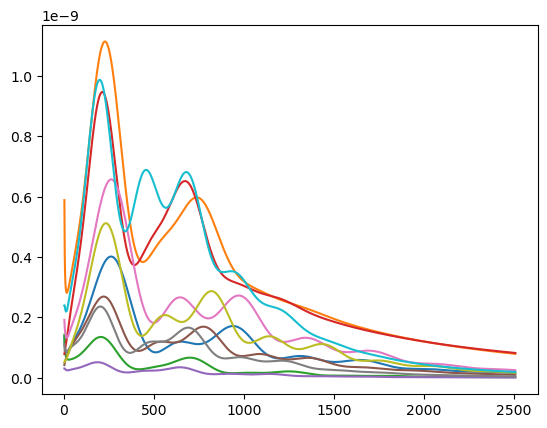

In [16]:
for i in range(10):
    plt.plot(ells, training_Dell[i])


In [20]:
training_peak_pos

[array([ 261,  652,  939, 1312, 1642]),
 array([227, 737]),
 array([ 204,  700, 1028, 1248, 1540, 1789]),
 array([213, 672]),
 array([ 186,  643,  917, 1138, 1398, 1623]),
 array([ 220,  544,  774, 1084, 1354]),
 array([ 263,  645,  971, 1342, 1686]),
 array([ 202,  498,  690,  975, 1207]),
 array([ 233,  560,  819, 1139, 1430, 1736, 2023]),
 array([198, 456, 679, 929]),
 array([ 209,  709, 1021, 1256, 1536, 1786]),
 array([ 194,  644,  948, 1143]),
 array([ 257,  609,  916, 1268, 1599, 1945, 2276]),
 array([   8,  226,  575,  798, 1112, 1382]),
 array([ 223,  532,  795, 1104, 1376]),
 array([186, 439, 647]),
 array([205, 488, 733, 995]),
 array([ 219,  555,  834, 1155, 1455, 1759]),
 array([   4,  194,  442,  662,  920, 1152]),
 array([ 250,  630,  896, 1252, 1563]),
 array([ 266,  708, 1111, 1520, 1929, 2337]),
 array([ 211,  709, 1024, 1253]),
 array([188, 669]),
 array([ 235,  582,  818, 1155, 1443, 1765, 2057]),
 array([203, 486, 714, 988]),
 array([ 222,  775, 1104, 1371, 1677, 1

In [6]:
from MomentEmu import *

In [7]:
PolyCell_CAMB = PolyEmu(training_params_array, training_Dell, testing_params_array[:8000], testing_Dell[:8000], backward=False, fractional_error=False, max_degree_forward=8)

Generating forward emulator...


In [8]:
test_pred_Dell = PolyCell_CAMB.forward_emulator(testing_params_array[8000:])

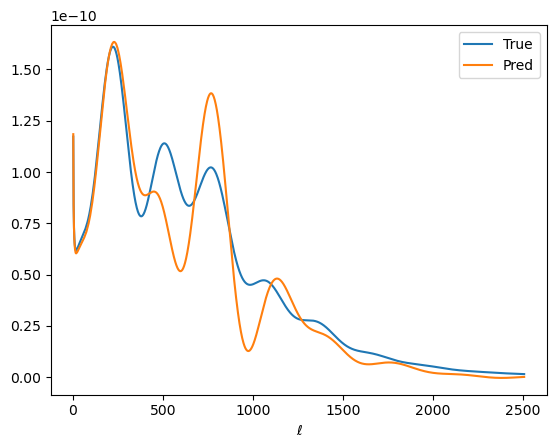

In [11]:
import matplotlib.pyplot as plt

n_list=[100, 200, 500, 700]
for n in n_list[0:1]:
    plt.plot(ells, testing_Dell[8000+n], label="True")
    plt.plot(ells, test_pred_Dell[n], label="Pred")
    
plt.xlabel("ℓ")
plt.legend()

In [15]:
PolyMoment_CAMB = PolyEmu(training_params_array, training_moments, testing_params_array, test_moments)

Generating forward emulator...


Generating backward emulator...


: 

## Instance study

In [ ]:
Ob, Oc, h, tau, ns, ln10_10_As = np.mean(training_parameters, axis=0)

H0 = h * 100
Obh2 = Ob * h**2
Och2 = Oc * h**2
As = np.exp(ln10_10_As) * 1e-10

import camb
from camb import model, initialpower
import numpy as np

# Set parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Obh2, omch2=Och2, tau=tau)
pars.InitPower.set_params(As=As, ns=ns)
pars.set_for_lmax(2500, lens_potential_accuracy=1)

# Run the calculation
results = camb.get_results(pars)
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')

# Extract TT spectrum
import matplotlib.pyplot as plt
cls = powers['total']
ell = range(cls.shape[0])

plt.plot(ell, cls[:,0])  # TT
plt.xlabel(r'$\ell$')
plt.yscale('log')
plt.ylabel(r'$D_\ell^{TT}$ [$\mu K^2$]')
plt.title('CMB TT Power Spectrum')
plt.show()

In [ ]:
test_moments_pred = PolyCAMB.forward_emulator(testing_params_array)

In [2]:
import numpy as np
np.argmin([1,2,3])

np.int64(0)